In [72]:
from ssd import SSD
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
import pickle

In [65]:
NUM_CLASSES = 2
model = SSD(NUM_CLASSES).SSD300()

In [66]:
# model.summary()

In [67]:
# model.load_weights('weights_SSD300.hdf5', by_name=True)

In [68]:
img_path = 'test1.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
x = img.reshape(-1, 300, 300, 3) / 255

In [69]:
y_pred = model.predict(x) 
# (sample, defaultbox, (4(cx, cy, w, h), 2(num_class), 8(xmin, ymin, xmax, ymax, varxc, varyc, varw, varh)))
y_pred[0, 0, :]

array([-4.8603586e-04,  2.8934819e-03,  2.5350938e-03, -1.5883800e-04,
        4.9980983e-01,  5.0019020e-01,  2.6315791e-03,  2.6315791e-03,
        2.3684211e-02,  2.3684211e-02,  1.0000000e-01,  1.0000000e-01,
        1.0000000e-01,  1.0000000e-01], dtype=float32)

In [70]:
from ssd_utils import BBoxUtility

In [73]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [81]:
gt = pickle.load(open('gt_pascal.pkl', 'rb'))

In [94]:
gt.keys()

dict_keys(['frame02089.png', 'frame04694.png', 'frame04594.png', 'frame03254.png', 'frame04175.png', 'frame04452.png', 'frame03475.png', 'frame01957.png', 'frame00565.png', 'frame00519.png', 'frame05289.png', 'frame01644.png', 'frame02488.png', 'frame04826.png', 'frame03858.png', 'frame00587.png', 'frame03325.png', 'frame05503.png', 'frame01196.png', 'frame02920.png', 'frame05643.png', 'frame03667.png', 'frame04030.png', 'frame02247.png', 'frame05098.png', 'frame04402.png', 'frame05303.png', 'frame02137.png', 'frame02708.png', 'frame04199.png', 'frame00195.png', 'frame03405.png', 'frame01063.png', 'frame02978.png', 'frame02780.png', 'frame03307.png', 'frame00282.png', 'frame02863.png', 'frame00144.png', 'frame01293.png', 'frame00689.png', 'frame01944.png', 'frame04089.png', 'frame00548.png', 'frame00478.png', 'frame03116.png', 'frame02633.png', 'frame00933.png', 'frame04183.png', 'frame03094.png', 'frame01246.png', 'frame02589.png', 'frame02922.png', 'frame05658.png', 'frame04283.png',

In [98]:
gt['frame02920.png']

array([[0.52734375, 0.05972222, 0.75703125, 0.27361111, 0.        ,
        0.        , 1.        ],
       [0.62421875, 0.28611111, 0.89140625, 0.575     , 1.        ,
        0.        , 0.        ],
       [0.1328125 , 0.66111111, 0.4078125 , 0.93333333, 0.        ,
        1.        , 0.        ],
       [0.74140625, 0.59861111, 0.93046875, 0.96805556, 0.        ,
        0.        , 1.        ]])

In [97]:
test_box = np.array([40, 90, 80, 160])/300
test_box

array([0.13333333, 0.3       , 0.26666667, 0.53333333])

In [64]:
test_box = np.array([[40, 90, 80, 160, 1, 0],
                    [100, 180, 140, 220, 0, 1]])
bbox_util.assign_boxes(test_box)

ValueError: shape mismatch: value array of shape (1,2) could not be broadcast to indexing result of shape (1,1)

In [55]:
results = bbox_util.detection_out(y_pred)

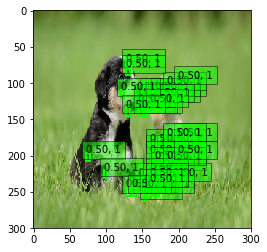

In [56]:
i = 0
det_label = results[i][:, 0]
det_conf = results[i][:, 1]
det_xmin = results[i][:, 2]
det_ymin = results[i][:, 3]
det_xmax = results[i][:, 4]
det_ymax = results[i][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.10]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()

plt.imshow(img / 255.)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * img.shape[1]))
    ymin = int(round(top_ymin[i] * img.shape[0]))
    xmax = int(round(top_xmax[i] * img.shape[1]))
    ymax = int(round(top_ymax[i] * img.shape[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

plt.show()